Plate detection and recognition

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


In [2]:
def load_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def show_image(img):
    plt.imshow(img, 'gray')

Prosecna visina: 89.08
Prosecna sirina: 287.82
Prosecan aspect ratio: 3.25


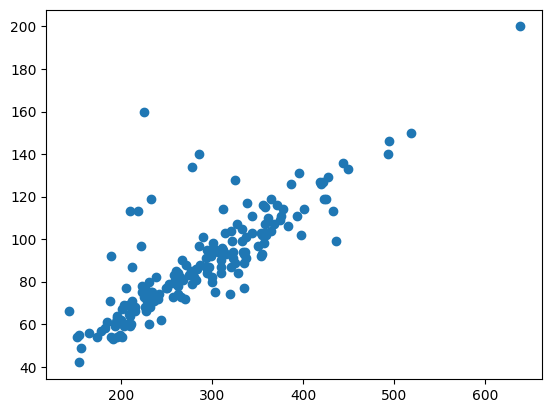

In [3]:
positive_images = []
negative_images = []

folder_path = '../datasets/train/'

aspect_ratios = []
widths = []
heights = []

for img_name in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_name)
    img = load_image(img_path)
    if 'plate' in img_name:
        positive_images.append(img)
        width = img.shape[1]
        height = img.shape[0]
        heights.append(height)
        widths.append(width)
        aspect_ratios.append(width/height)

    elif 'neg' in img_name:
        negative_images.append(img)

print(f'Prosecna visina: {sum(heights)/len(positive_images):.2f}')
print(f'Prosecna sirina: {sum(widths)/len(positive_images):.2f}')
avg_aspect_ratio = sum(aspect_ratios) / len(aspect_ratios)
print(f'Prosecan aspect ratio: {avg_aspect_ratio:.2f}')
plt.scatter(widths, heights)
plt.show()


In [4]:
new_width = 200
new_height = int(new_width / avg_aspect_ratio)

for i, img in enumerate(positive_images):
    positive_images[i] = cv2.resize(img, (new_width, new_height))

for i, img in enumerate(negative_images):
    negative_images[i] = cv2.resize(img, (new_width, new_height))


In [5]:
positive_features = []
negative_features = []
labels = []

nbins = 9
cell_size = (8, 8)
block_size = (3, 3)

hog = cv2.HOGDescriptor(_winSize=(new_width // cell_size[1] * cell_size[1], 
                                  new_height // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

for img in positive_images:
    positive_features.append(hog.compute(img))
    labels.append(1)

for img in negative_images:
    negative_features.append(hog.compute(img))
    labels.append(0)

positive_features = np.array(positive_features)
negative_features = np.array(negative_features)
x = np.vstack((positive_features, negative_features))
y = np.array(labels)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, random_state=42)

svm = SVC(kernel='linear', probability=True)
svm.fit(x_train, y_train)

y_train_pred = svm.predict(x_train)
y_val_pred = svm.predict(x_val)
print(f'Train accuracy:{accuracy_score(y_train, y_train_pred)}')
print(f'Validation accuracy:{accuracy_score(y_val, y_val_pred)}')


Train accuracy:1.0
Validation accuracy:0.9857142857142858
